In [1]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [2]:
import os 
from os import listdir
from tqdm import tqdm
import shutil
import cv2
import torch 
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from torch.optim import lr_scheduler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.decomposition import PCA

In [ ]:
train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.8023, 0.6521, 0.7710], [0.0916, 0.1192, 0.0908])
    ])

test_transform = torchvision.transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.8023, 0.6521, 0.7710], [0.0916, 0.1192, 0.0908])
    ])

In [3]:
data40x = torchvision.datasets.ImageFolder("./drive/MyDrive/breast40")

In [4]:
class MapDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0] 
        y = self.dataset[index][1]       
        return x, y

    def __getlabel__(self,index):
        return self.dataset[index][1]
        
    def __len__(self):
        return len(self.dataset)

In [ ]:
traindataset = MapDataset(data40x,train_transform)
valdataset = MapDataset(data40x,test_transform)

In [ ]:
dataset_size = 2003
indices = list(range(dataset_size))
split = int(np.floor(0.15 * dataset_size))

np.random.seed(1234)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

x_train = torch.utils.data.Subset(traindataset, indices=train_indices)
x_test = torch.utils.data.Subset(valdataset, indices=val_indices)

In [ ]:
mean  = torch.tensor([0.0, 0.0, 0.0])
std = torch.tensor([0.0, 0.0, 0.0])
nb_samples = 0

for i in range(round(0.8*2003)):
    
    images = x_train[i][0]
    meanA = torch.zeros(3)
    meanA[0] = images[0, :, :].mean()
    meanA[1] = images[1, :, :].mean()
    meanA[2] = images[2, :, :].mean()
    mean += meanA
    sdA = torch.zeros(3)
    sdA[0] = images[0, :, :].flatten().std()
    sdA[1] = images[1, :, :].flatten().std()
    sdA[2] = images[2, :, :].flatten().std()
    std += sdA
    nb_samples += 1

mean /= nb_samples
std /= nb_samples
print(mean)#[0.8023, 0.6521, 0.7710]
print(std)#[0.0916, 0.1192, 0.0908]

In [ ]:
def count_labels(data,len):
  p = 0
  for i in range(len):
    p += data[i][1]
  print("Class 0: ",len-p,"Class 1: ",p)
  

In [ ]:
count_labels(x_train,round(0.85*(654+1349)))

Class 0:  550 Class 1:  1153


In [ ]:
count_labels(x_test,round(0.15*(654+1349)))

Class 0:  104 Class 1:  196


In [ ]:
count_labels(total)

Class 0:  654 Class 1:  1349


In [ ]:
target = np.zeros(round(0.85*(654+1349)))
for i in range(round(0.85*(654+1349))):
  target[i] = x_train[i][1]

torch.save(target,"./drive/MyDrive/breast/target" )

In [7]:
target = torch.load("./drive/MyDrive/breast/target" )
target = target.astype(int)

In [ ]:
class_sample_count = np.array([len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count

samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

In [ ]:
train_loader =  torch.utils.data.DataLoader(x_train, batch_size=32,sampler=sampler)
validation_loader =  torch.utils.data.DataLoader(x_test, batch_size=1, shuffle=False)

In [ ]:
class Net5Conv(nn.Module):
    def __init__(self):
        super(Net5Conv, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=10, stride=4)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=4, stride=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=2, stride=1)


        # Pooling (Max)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(9216, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

        # Dropout
        self.dropout2d = nn.Dropout2d(p=0.3)
        self.dropout = nn.Dropout(p=0.3)

        #Normalisation
        self.norm = nn.LayerNorm(512)

    def forward(self, x):
        x = self.maxpool2(self.dropout2d(F.relu(self.conv1(x))))
        x = self.maxpool1(self.dropout2d(F.relu(self.conv2(x))))
        x = self.maxpool2(self.dropout2d(F.relu(self.conv3(x))))
        x = self.dropout2d(F.relu(self.conv4(x)))
        x = self.dropout2d(F.relu(self.conv5(x)))

        x = torch.flatten(x,1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.norm(x)
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.sigmoid(self.fc3(x))

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net5Conv().to(device)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.002)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

val_acc = []
train_acc = []
train_loss = []
val_loss = []

num_epochs = 25
for i in range(num_epochs):
  model.train()
  ground_truthVal = []
  predVal = []
  c = 0
  for images, labels in train_loader:
        predTrain = []
        ground_truthTrain = []
        images, labels = images.float().to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        loss = loss_fn(outputs.to(device), labels.unsqueeze(1).type(torch.FloatTensor).to(device))
        loss.backward()
        optimizer.step()

        predicted = torch.round(outputs)
        predTrain.extend(predicted.detach().cpu().numpy().flatten().tolist())
        ground_truthTrain.extend(labels.detach().cpu().numpy().flatten().tolist())

        c+=1
        if c%10 == 0:
          accuracy = accuracy_score(ground_truthTrain, predTrain)
          print('Epoch: {}. Loss: {}. Accuracy on trainset: {}'.format(i, loss.item(), accuracy))

  train_loss.append(loss.item())
  accuracy = accuracy_score(ground_truthTrain, predTrain)
  train_acc.append(accuracy)
  for images, labels in validation_loader:#validation
      model.eval()
      with torch.no_grad():
        images, labels = images.float().to(device), labels.to(device)
        
        outputs = model(images)

        predicted = torch.round(outputs)
        predVal.extend(predicted.detach().cpu().numpy().flatten().tolist())
        ground_truthVal.extend(labels.detach().cpu().numpy().flatten().tolist())
      
  print(confusion_matrix(ground_truthVal,predVal))
  loss = loss_fn(outputs.to(device), labels.unsqueeze(1).type(torch.FloatTensor).to(device))
  val_loss.append(loss.item())
  accuracy = accuracy_score(ground_truthVal, predVal)
  val_acc.append(accuracy)
  print('Accuracy in validation: {}'.format(accuracy))
  exp_lr_scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0. Loss: 0.7388385534286499. Accuracy on trainset: 0.4375
Epoch: 0. Loss: 0.6736472845077515. Accuracy on trainset: 0.5625
Epoch: 0. Loss: 0.6405572891235352. Accuracy on trainset: 0.65625
Epoch: 0. Loss: 0.6957350969314575. Accuracy on trainset: 0.625
Epoch: 0. Loss: 0.670764148235321. Accuracy on trainset: 0.625
[[ 60  44]
 [ 21 175]]
Accuracy in validation: 0.7833333333333333
Epoch: 1. Loss: 0.675675630569458. Accuracy on trainset: 0.625
Epoch: 1. Loss: 0.5395930409431458. Accuracy on trainset: 0.71875
Epoch: 1. Loss: 0.5045977234840393. Accuracy on trainset: 0.8125
Epoch: 1. Loss: 0.5388470888137817. Accuracy on trainset: 0.75
Epoch: 1. Loss: 0.48381924629211426. Accuracy on trainset: 0.78125
[[ 85  19]
 [ 69 127]]
Accuracy in validation: 0.7066666666666667
Epoch: 2. Loss: 0.4919010102748871. Accuracy on trainset: 0.78125
Epoch: 2. Loss: 0.48272258043289185. Accuracy on trainset: 0.78125
Epoch: 2. Loss: 0.5920377969741821. Accuracy on trainset: 0.6875
Epoch: 2. Loss: 0.39726

In [ ]:
print("Accuracy: ",accuracy_score(ground_truthVal, predVal))
print("Precision: ",precision_score(ground_truthVal,predVal))
print("Recall: ",recall_score(ground_truthVal,predVal))

Accuracy:  0.8433333333333334
Precision:  0.8340807174887892
Recall:  0.9489795918367347


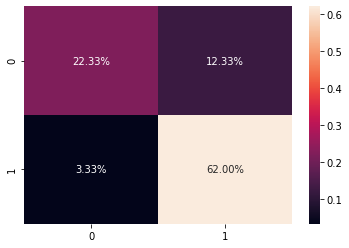

In [ ]:
cf_matrix = confusion_matrix(ground_truthVal,predVal)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')

In [ ]:
torch.save(model.state_dict(),"./drive/MyDrive/ModelFullHist5Conv" )

In [ ]:
print("Accuracy: ",accuracy_score(ground_truthVal, predVal))
print("Precision: ",precision_score(ground_truthVal,predVal))
print("Recall: ",recall_score(ground_truthVal,predVal))

Accuracy:  0.8433333333333334
Precision:  0.8340807174887892
Recall:  0.9489795918367347


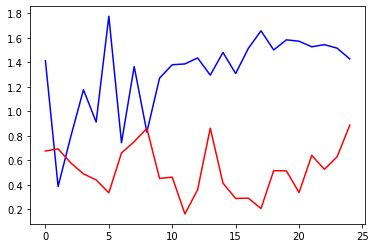

In [ ]:
plt.plot(np.arange(len(val_acc)),val_loss,color="blue")
plt.plot(np.arange(len(val_acc)),train_loss,color="red")

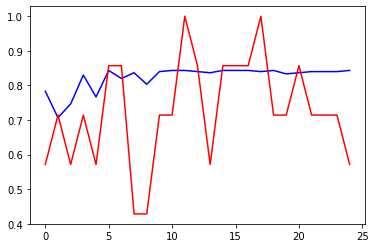

In [ ]:
plt.plot(np.arange(len(val_acc)),val_acc,color="blue")
plt.plot(np.arange(len(val_acc)),train_acc,color="red")

# CNN on cropped images

In [8]:
train_transform = transforms.Compose([
        transforms.RandomCrop(230),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.8023, 0.6521, 0.7710], [0.0916, 0.1192, 0.0908])
    ])

test_transform = torchvision.transforms.Compose([
        transforms.CenterCrop(230),
        transforms.ToTensor(),
        transforms.Normalize([0.8023, 0.6521, 0.7710], [0.0916, 0.1192, 0.0908])
    ])

#We also define another transformation which will be used for the information fusion
final_transform = torchvision.transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.8023, 0.6521, 0.7710], [0.0916, 0.1192, 0.0908])
    ])

traindataset = MapDataset(data40x,train_transform)
valdataset = MapDataset(data40x,test_transform)
testdataset = MapDataset(data40x,final_transform)

dataset_size = 2003
indices = list(range(dataset_size))
split = int(np.floor(0.15 * dataset_size))

np.random.seed(1234)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

x_train = torch.utils.data.Subset(traindataset, indices=train_indices)
x_test = torch.utils.data.Subset(valdataset, indices=val_indices)
x_final = torch.utils.data.Subset(testdataset, indices=val_indices)

In [17]:
class_sample_count = np.array([len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count

samples_weight = np.array([weight[t] for t in target])

samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader =  torch.utils.data.DataLoader(x_train, batch_size=32,sampler=sampler)
validation_loader =  torch.utils.data.DataLoader(x_test, batch_size=1, shuffle=False)
test_loader =  torch.utils.data.DataLoader(x_final, batch_size=1, shuffle=False)

In [11]:
class Net5Conv(nn.Module):
    def __init__(self):
        super(Net5Conv, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=10, stride=4)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=4, stride=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=2, stride=1)


        # Pooling (Max)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(1024, 512)  

        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

        # 2d (Conv) Dropout
        self.dropout2d = nn.Dropout2d(p=0.3)

        # FC dropout
        self.dropout = nn.Dropout(p=0.3)

        self.norm = nn.LayerNorm(512)

    def forward(self, x):
        x = self.maxpool2(self.dropout2d(F.relu(self.conv1(x))))
        x = self.maxpool2(self.dropout2d(F.relu(self.conv2(x))))
        x = self.maxpool2(self.dropout2d(F.relu(self.conv3(x))))
        x = self.dropout2d(F.relu(self.conv4(x)))
        x = self.dropout2d(F.relu(self.conv5(x)))

        x = torch.flatten(x,1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.norm(x)
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.sigmoid(self.fc3(x))

        return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Net5Conv().to(device)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

val_acc = []
train_acc = []
train_loss = []
val_loss = []

num_epochs = 25
for i in range(num_epochs):
  model.train()
  ground_truthVal = []
  predVal = []
  c = 0
  for images, labels in train_loader:
        predTrain = []
        ground_truthTrain = []
        images, labels = images.float().to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        loss = loss_fn(outputs.to(device), labels.unsqueeze(1).type(torch.FloatTensor).to(device))
        loss.backward()
        optimizer.step()

        predicted = torch.round(outputs)
        predTrain.extend(predicted.detach().cpu().numpy().flatten().tolist())
        ground_truthTrain.extend(labels.detach().cpu().numpy().flatten().tolist())

        c+=1
        if c%10 == 0:
          accuracy = accuracy_score(ground_truthTrain, predTrain)
          print('Epoch: {}. Loss: {}. Accuracy on trainset: {}'.format(i, loss.item(), accuracy))
  train_loss.append(loss.item())
  accuracy = accuracy_score(ground_truthTrain, predTrain)
  train_acc.append(accuracy)
  for images, labels in validation_loader:#validation
      model.eval()
      with torch.no_grad():
        images, labels = images.float().to(device), labels.to(device)
        
        outputs = model(images)
        predicted = torch.round(outputs)
        predVal.extend(predicted.detach().cpu().numpy().flatten().tolist())
        ground_truthVal.extend(labels.detach().cpu().numpy().flatten().tolist())
      
  print(confusion_matrix(ground_truthVal,predVal))
  loss = loss_fn(outputs.to(device), labels.unsqueeze(1).type(torch.FloatTensor).to(device))
  val_loss.append(loss.item())
  accuracy = accuracy_score(ground_truthVal, predVal)
  val_acc.append(accuracy)
  print('Accuracy in validation: {}'.format(accuracy))
  exp_lr_scheduler.step()

torch.save(model.state_dict(),"./drive/MyDrive/ModelHistCrop5Conv" )

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0. Loss: 0.6768765449523926. Accuracy on trainset: 0.625
Epoch: 0. Loss: 0.6870213150978088. Accuracy on trainset: 0.5
Epoch: 0. Loss: 0.7333025336265564. Accuracy on trainset: 0.40625
Epoch: 0. Loss: 0.7007218599319458. Accuracy on trainset: 0.4375
Epoch: 0. Loss: 0.6924092173576355. Accuracy on trainset: 0.46875
[[ 65  39]
 [ 49 147]]
Accuracy in validation: 0.7066666666666667
Epoch: 1. Loss: 0.7576899528503418. Accuracy on trainset: 0.28125
Epoch: 1. Loss: 0.6031465530395508. Accuracy on trainset: 0.71875
Epoch: 1. Loss: 0.5582099556922913. Accuracy on trainset: 0.8125
Epoch: 1. Loss: 0.5514525175094604. Accuracy on trainset: 0.84375
Epoch: 1. Loss: 0.6346153020858765. Accuracy on trainset: 0.59375
[[ 67  37]
 [ 25 171]]
Accuracy in validation: 0.7933333333333333
Epoch: 2. Loss: 0.48953649401664734. Accuracy on trainset: 0.71875
Epoch: 2. Loss: 0.6106158494949341. Accuracy on trainset: 0.65625
Epoch: 2. Loss: 0.5215552449226379. Accuracy on trainset: 0.8125
Epoch: 2. Loss: 0.

Accuracy:  0.8333333333333334
Precision:  0.8258928571428571
Recall:  0.9438775510204082


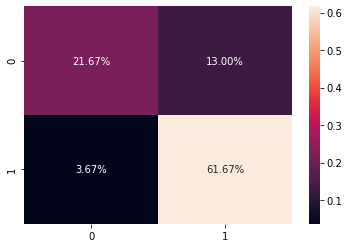

In [ ]:
print("Accuracy: ",accuracy_score(ground_truthVal, predVal))
print("Precision: ",precision_score(ground_truthVal,predVal))
print("Recall: ",recall_score(ground_truthVal,predVal))

cf_matrix = confusion_matrix(ground_truthVal,predVal)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')

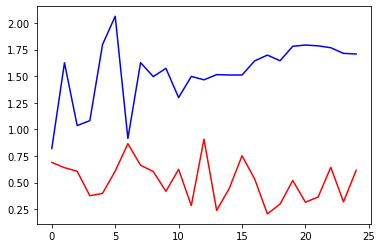

In [ ]:
plt.plot(np.arange(len(val_acc)),val_loss,color="blue")
plt.plot(np.arange(len(val_acc)),train_loss,color="red")

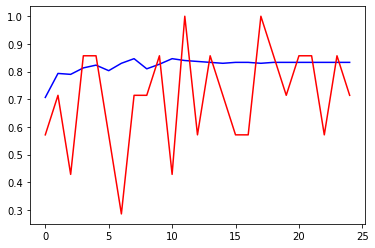

In [ ]:
plt.plot(np.arange(len(val_acc)),val_acc,color="blue")
plt.plot(np.arange(len(val_acc)),train_acc,color="red")

In [21]:
predVal = []
ground_truthVal = []
model = model.to("cpu")
model.eval()
for images, labels in test_loader:
  res = torch.zeros(6)
  img1 = images[:,:,0:230,3:233]
  res[0] = model(img1)
  img2 = images[:,:,230:460,3:233]
  res[1] = model(img2)

  img3 = images[:,:,0:230,236:466]
  res[2] = model(img3)
  img4 = images[:,:,230:460,236:466]
  res[3] = model(img4)

  img5 = images[:,:,0:230,469:699]
  res[4] = model(img5)
  img6 = images[:,:,230:460,469:699]
  res[5] = model(img6)

  predicted = torch.round(res.mean())
  predVal.extend(predicted.detach().cpu().numpy().flatten().tolist())
  ground_truthVal.extend(labels.detach().cpu().numpy().flatten().tolist())

print(confusion_matrix(ground_truthVal,predVal))
print("Accuracy: ",accuracy_score(ground_truthVal,predVal))
print("Precision: ",precision_score(ground_truthVal,predVal))
print("Recall: ",recall_score(ground_truthVal,predVal))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[[ 70  34]
 [ 14 182]]
Accuracy:  0.84
Precision:  0.8425925925925926
Recall:  0.9285714285714286


# ResNet18

In [ ]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)
model.fc = nn.Linear(512, 1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

val_acc = []
train_acc = []
train_loss = []
val_loss = []

num_epochs = 10
for i in range(num_epochs):
  model.train()
  ground_truthVal = []
  predVal = []
  c = 0
  for images, labels in train_loader:
        predTrain = []
        ground_truthTrain = []
        images, labels = images.float().to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)

        loss = loss_fn(torch.sigmoid(outputs.to(device)), labels.unsqueeze(1).type(torch.FloatTensor).to(device))
        loss.backward()
        optimizer.step()

        predicted = torch.round(torch.sigmoid(outputs))
        predTrain.extend(predicted.detach().cpu().numpy().flatten().tolist())
        ground_truthTrain.extend(labels.detach().cpu().numpy().flatten().tolist())

        c+=1
        if c%10 == 0:
          accuracy = accuracy_score(ground_truthTrain, predTrain)
          print('Epoch: {}. Loss: {}. Accuracy on trainset: {}'.format(i, loss.item(), accuracy))
  train_loss.append(loss.item())
  accuracy = accuracy_score(ground_truthTrain, predTrain)
  train_acc.append(accuracy)
  for images, labels in validation_loader:#validation
      model.eval()
      with torch.no_grad():
        images, labels = images.float().to(device), labels.to(device)
        
        outputs = model(images)

        predicted = torch.round(torch.sigmoid(outputs))
        predVal.extend(predicted.detach().cpu().numpy().flatten().tolist())
        ground_truthVal.extend(labels.detach().cpu().numpy().flatten().tolist())
      
  print(confusion_matrix(ground_truthVal,predVal))
  loss = loss_fn(torch.sigmoid(outputs).to(device), labels.unsqueeze(1).type(torch.FloatTensor).to(device))
  val_loss.append(loss.item())
  accuracy = accuracy_score(ground_truthVal, predVal)
  val_acc.append(accuracy)
  print('Accuracy in validation: {}'.format(accuracy))
  exp_lr_scheduler.step()

torch.save(model.state_dict(),"./drive/MyDrive/ResNet18HistWeightCrop" )

Epoch: 0. Loss: 0.6904951333999634. Accuracy on trainset: 0.46875
Epoch: 0. Loss: 0.6450127363204956. Accuracy on trainset: 0.53125
Epoch: 0. Loss: 0.5387852787971497. Accuracy on trainset: 0.78125
Epoch: 0. Loss: 0.4593658447265625. Accuracy on trainset: 0.78125
Epoch: 0. Loss: 0.39291080832481384. Accuracy on trainset: 0.875
[[ 91  13]
 [ 28 168]]
Accuracy in validation: 0.8633333333333333
Epoch: 1. Loss: 0.4574741721153259. Accuracy on trainset: 0.875
Epoch: 1. Loss: 0.3752782940864563. Accuracy on trainset: 0.90625
Epoch: 1. Loss: 0.2710437774658203. Accuracy on trainset: 0.84375
Epoch: 1. Loss: 0.3994637131690979. Accuracy on trainset: 0.8125
Epoch: 1. Loss: 0.169732004404068. Accuracy on trainset: 1.0
[[ 99   5]
 [ 21 175]]
Accuracy in validation: 0.9133333333333333
Epoch: 2. Loss: 0.2672071158885956. Accuracy on trainset: 0.90625
Epoch: 2. Loss: 0.2378271073102951. Accuracy on trainset: 0.9375
Epoch: 2. Loss: 0.20229363441467285. Accuracy on trainset: 0.90625
Epoch: 2. Loss: 0.4

Accuracy:  0.9666666666666667
Precision:  0.984375
Recall:  0.9642857142857143


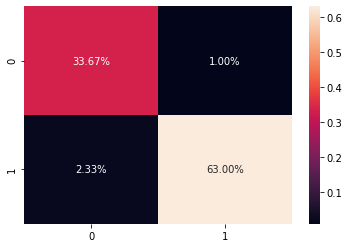

In [ ]:
cf_matrix = confusion_matrix(ground_truthVal,predVal)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')
print("Accuracy: ",accuracy_score(ground_truthVal,predVal))
print("Precision: ",precision_score(ground_truthVal,predVal))
print("Recall: ",recall_score(ground_truthVal,predVal))

In [ ]:
predVal = []
ground_truthVal = []
model = model.to("cpu")
model.eval()
for images, labels in test_loader:
  res = torch.zeros(6)
  img1 = images[:,:,0:230,3:233]
  res[0] = torch.sigmoid(model(img1))
  img2 = images[:,:,230:460,3:233]
  res[1] = torch.sigmoid(model(img2))

  img3 = images[:,:,0:230,236:466]
  res[2] = torch.sigmoid(model(img3))
  img4 = images[:,:,230:460,236:466]
  res[3] = torch.sigmoid(model(img4))

  img5 = images[:,:,0:230,469:699]
  res[4] = torch.sigmoid(model(img5))
  img6 = images[:,:,230:460,469:699]
  res[5] = torch.sigmoid(model(img6))

  predicted = torch.round(res.mean())
  predVal.extend(predicted.detach().cpu().numpy().flatten().tolist())
  ground_truthVal.extend(labels.detach().cpu().numpy().flatten().tolist())

print(confusion_matrix(ground_truthVal,predVal))
print("Accuracy: ",accuracy_score(ground_truthVal,predVal))
print("Precision: ",precision_score(ground_truthVal,predVal))
print("Recall: ",recall_score(ground_truthVal,predVal))

[[103   1]
 [  5 191]]
Accuracy:  0.98
Precision:  0.9947916666666666
Recall:  0.9744897959183674


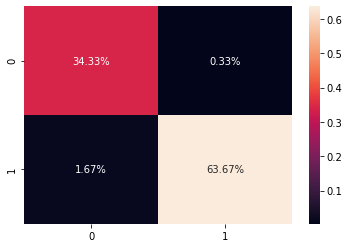

In [ ]:
cf_matrix = confusion_matrix(ground_truthVal,predVal)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')

# SVM with convolutional features

In [ ]:
PATH="./drive/MyDrive/ResNet18HistWeightCrop"
from torchvision.models import resnet18
model = resnet18()
model.fc = nn.Linear(512,1)
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
train_loader =  torch.utils.data.DataLoader(x_train, batch_size=1)#We change the batch size to 1 for accessing the convulotional features
validation_loader =  torch.utils.data.DataLoader(x_test, batch_size=1)

In [ ]:
TrainFeaturesResNet = torch.zeros(round(0.85*(654+1349)),512)
labelsTrain = torch.zeros(round(0.85*(654+1349)))
c=0
for img,label in train_loader:
  model.avgpool.register_forward_hook(get_activation('avgpool'))
  output = model(img)
  TrainFeaturesResNet[c] = activation['avgpool'].squeeze(2).squeeze(2)
  labelsTrain[c] = label
  c+=1


In [ ]:
torch.save(labelsTrain,"./drive/MyDrive/breast/targetTrain" )
torch.save(TrainFeaturesResNet,"./drive/MyDrive/breast/featuresTrain" )

In [ ]:
TestFeaturesResNet = torch.zeros(round(0.15*(654+1349)),512)
labelsTest = torch.zeros(round(0.15*(654+1349)))
c=0
for img,label in validation_loader:
  model.avgpool.register_forward_hook(get_activation('avgpool'))
  output = model(img)
  TestFeaturesResNet[c] = activation['avgpool'].squeeze(2).squeeze(2)
  labelsTest[c] = label
  c+=1


In [ ]:
torch.save(labelsTest,"./drive/MyDrive/breast/targetTest" )
torch.save(TestFeaturesResNet,"./drive/MyDrive/breast/featuresTest" )

In [ ]:
targetTrain = torch.load("./drive/MyDrive/breast/targetTrain")
featuresTrain = torch.load("./drive/MyDrive/breast/featuresTrain")

targetTest = torch.load("./drive/MyDrive/breast/targetTest")
featuresTest = torch.load("./drive/MyDrive/breast/featuresTest")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

res = svc_param_selection(np.concatenate((featuresTrain,featuresTest)),np.concatenate((targetTrain,targetTest)),5)

In [ ]:
res

{'C': 1, 'gamma': 1}

In [ ]:
from sklearn import svm
classif = svm.SVC(kernel='rbf', gamma=1,C=1) 

classif.fit(featuresTrain, targetTrain)

y_pred = classif.predict(featuresTest)
y_predTr = classif.predict(featuresTrain)

print("Accuracy train:",accuracy_score(targetTrain, y_predTr))
print("Accuracy test:",accuracy_score(targetTest, y_pred))

Accuracy train: 0.7668819729888432
Accuracy test: 0.6533333333333333


We could keep  370 components


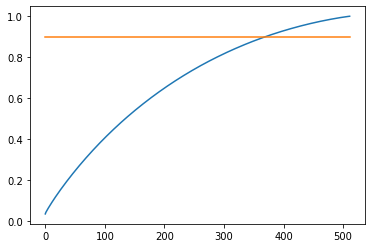

In [ ]:
resPCA = PCA()
resPCA.fit(featuresTrain)

cumsum = np.cumsum(resPCA.explained_variance_ratio_)
plt.plot(np.arange(len(resPCA.explained_variance_ratio_)),cumsum)
line = np.repeat(0.9,[len(resPCA.explained_variance_ratio_)])
plt.plot(line)
N = np.where(cumsum>=0.9)[0][0]
print("We could keep ",N,"components")

In [ ]:
featuresTrainPCA = resPCA.fit_transform(featuresTrain,N)
featuresTestPCA = resPCA.transform(featuresTest)

In [ ]:
res = svc_param_selection(np.concatenate((featuresTrainPCA,featuresTestPCA)),np.concatenate((targetTrain,targetTest)),5)

In [ ]:
res

{'C': 1, 'gamma': 1}

In [ ]:
classif = svm.SVC(kernel='rbf', gamma=1,C=1)  

classif.fit(featuresTrainPCA, targetTrain)

y_pred = classif.predict(featuresTestPCA)
y_predTr = classif.predict(featuresTrainPCA)

print("Accuracy train:",accuracy_score(targetTrain, y_predTr))
print("Accuracy test:",accuracy_score(targetTest, y_pred))

Accuracy train: 0.7668819729888432
Accuracy test: 0.6533333333333333


In [ ]:
def svc_param_selection(X, y, nfolds):
    Cs = np.arange(0.5,5,0.5)
    gammas = np.arange(0.5,5,0.5)
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
res = svc_param_selection(np.concatenate((featuresTrainPCA,featuresTestPCA)),np.concatenate((targetTrain,targetTest)),5)

In [ ]:
res

{'C': 1.5, 'gamma': 2.5}

In [ ]:
classif = svm.SVC(kernel='rbf', gamma=2.5,C=1.5,class_weight=a)

classif.fit(featuresTrainPCA, targetTrain)

y_pred = classif.predict(featuresTestPCA)
y_predTr = classif.predict(featuresTrainPCA)

print("Accuracy train:",accuracy_score(targetTrain, y_predTr))
print("Accuracy test:",accuracy_score(targetTest, y_pred))


Accuracy train: 0.6770405167351732
Accuracy test: 0.6533333333333333
